<a href="https://colab.research.google.com/github/Kittyma3/naan-mudhalvan/blob/main/Product_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-cell-phones-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F363619%2F861634%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T135232Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D73bfbc23e65c9cab3b1b26640e2d5f617f02211766e68fe06bcb159f9a3014802f5999c3890b4a2edf5b6e2fb5359cf2527c18670da243d76e7eea8721e0969538ef55f221743dd1586b42ecd3f7ca684490911195180a43e1c1a31d8044168e420de621c176e4cf77aa9cc5b86e05b58494d82a4ae3ec5bf3bb606b27a2cf9df1ff208f2cd8f472665bed54034cd21c5706a7f296753619b60b058214e035034ffebfa058d73ff9583a3f8946156deae8960090e6d10712f39ab911bc7af68916bbbc78d804aab567f5749f7c283c28c1295f521d9926c8cfd9aadf55888ba9bce0473acbd68f83f86a1f23fa3646134b06f92b1707e3bfae0c80e4f80c2669'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9274620 bytes downloaded
Downloaded and uncompressed: amazon-cell-phones-reviews
Data source import complete.


In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-cell-phones-reviews/20191226-items.csv
/kaggle/input/amazon-cell-phones-reviews/20191226-reviews.csv


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
sentiments = SentimentIntensityAnalyzer()

In [22]:
data = pd.read_csv("/kaggle/input/amazon-cell-phones-reviews/20191226-reviews.csv")
print(data.head())

         asin           name  rating               date  verified  \
0  B0000SX2UC          Janet       3   October 11, 2005     False   
1  B0000SX2UC     Luke Wyatt       1    January 7, 2004     False   
2  B0000SX2UC         Brooke       5  December 30, 2003     False   
3  B0000SX2UC  amy m. teague       3     March 18, 2004     False   
4  B0000SX2UC  tristazbimmer       4    August 28, 2005     False   

                                          title  \
0                   Def not best, but not worst   
1                   Text Messaging Doesn't Work   
2                               Love This Phone   
3                       Love the Phone, BUT...!   
4  Great phone service and options, lousy case!   

                                                body  helpfulVotes  
0  I had the Samsung A600 for awhile which is abs...           1.0  
1  Due to a software issue between Nokia and Spri...          17.0  
2  This is a great, reliable phone. I also purcha...           5.0  
3 

In [23]:
print(data.describe())

             rating  helpfulVotes
count  67986.000000  27215.000000
mean       3.807916      8.229690
std        1.582906     31.954877
min        1.000000      1.000000
25%        3.000000      1.000000
50%        5.000000      2.000000
75%        5.000000      5.000000
max        5.000000    990.000000


In [24]:
data = data.dropna()
data

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
...,...,...,...,...,...,...,...,...
67978,B081H6STQQ,Rock Edge,5,"July 16, 2019",False,Candy bar phone is back!,Update 8/14/19 5 stars now! I've been using th...,12.0
67979,B081H6STQQ,Cindy Cowles,3,"July 17, 2019",False,Updated review,Update: If you like sending and receiving pict...,2.0
67980,B081H6STQQ,Los Kositos,5,"October 7, 2019",False,From iPhone to Android and loving it,I love my new phone. I've been dying to do a r...,1.0
67981,B081H6STQQ,jande,5,"August 16, 2019",False,"Awesome Phone, but finger scanner is a big mis...",I love the camera on this phone. The screen is...,1.0


In [25]:
ratings = data["rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

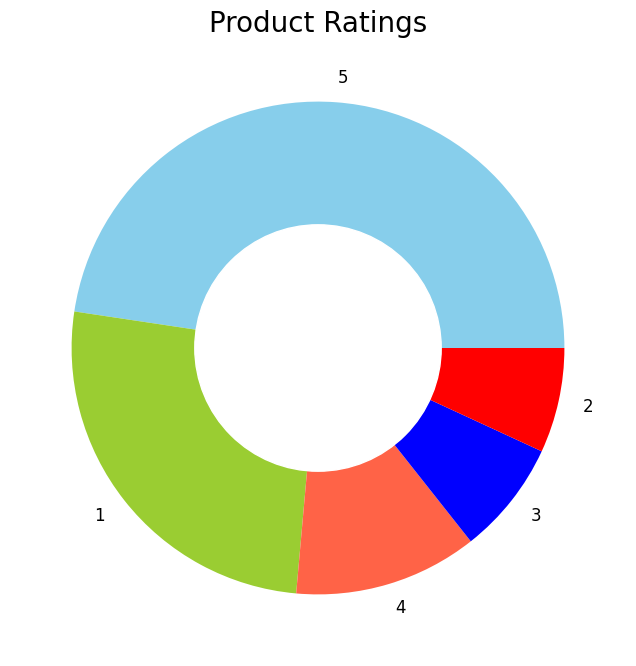

In [26]:
custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Product Ratings", fontsize=20)
plt.show()

In [27]:
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["body"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["body"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["body"]]
print(data.head())

         asin           name  rating               date  verified  \
0  B0000SX2UC          Janet       3   October 11, 2005     False   
1  B0000SX2UC     Luke Wyatt       1    January 7, 2004     False   
2  B0000SX2UC         Brooke       5  December 30, 2003     False   
3  B0000SX2UC  amy m. teague       3     March 18, 2004     False   
4  B0000SX2UC  tristazbimmer       4    August 28, 2005     False   

                                          title  \
0                   Def not best, but not worst   
1                   Text Messaging Doesn't Work   
2                               Love This Phone   
3                       Love the Phone, BUT...!   
4  Great phone service and options, lousy case!   

                                                body  helpfulVotes  Positive  \
0  I had the Samsung A600 for awhile which is abs...           1.0     0.105   
1  Due to a software issue between Nokia and Spri...          17.0     0.104   
2  This is a great, reliable phone. I 

In [28]:
x = sum(data["Positive"])
y = sum(data["Negative"])
z = sum(data["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [29]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  5021.1730000000025
Negative:  1756.803999999994
Neutral:  20415.93600000008
